In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from functools import partial
from typing import Optional
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from torchvision.utils import make_grid

In [4]:
USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: True


# Data

In [5]:
import numpy as np
from typing import Tuple

import torchvision


def load_MNIST() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_data = torchvision.datasets.MNIST(root="./", train=False, download=True)
    train_data, test_data = train_data.data.numpy(), test_data.data.numpy()
    axis_index = len(train_data.shape)
    train_data = np.expand_dims(train_data, axis=axis_index)
    test_data = np.expand_dims(test_data, axis=axis_index)

    return train_data, test_data


def load_CIFAR10() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data


def _load_dataset(name: str) -> Tuple[np.ndarray, np.ndarray]:
    if name == "mnist":
        return load_MNIST()
    elif name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the values 'mnist' or 'cifar10'")


def load_dataset(
    name: str, flatten: bool = False, binarize: bool = False
) -> Tuple[np.ndarray, np.ndarray]:

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [6]:
train_data, test_data = load_dataset('mnist')

100%|██████████| 9912422/9912422 [00:00<00:00, 139001782.82it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107580545.14it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 81726872.40it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18195347.44it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
BATCH_SIZE = 16

In [8]:
mnist_dataset_28 = TensorDataset(torch.from_numpy(train_data)) # create your datset
mnist_dataloader_28 = DataLoader(mnist_dataset_28, batch_size=BATCH_SIZE)

In [9]:
resize_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32),
                                                  torchvision.transforms.ToTensor()])
mnist_dataset_32 = torchvision.datasets.MNIST('', download=False, transform=resize_transform)
mnist_dataloader_32 = DataLoader(mnist_dataset_32, batch_size=BATCH_SIZE)

In [10]:
train_data, test_data = load_dataset('cifar10')
cifar_dataset = TensorDataset(torch.from_numpy(train_data)) # create your datset
cifar_dataloader = DataLoader(cifar_dataset, batch_size=BATCH_SIZE)

100%|██████████| 170498071/170498071 [00:05<00:00, 28547994.02it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


# Download models

In [54]:
from models import UNet, NoiseConditionalScoreNetwork

In [12]:
import models

In [111]:
import importlib
importlib.reload(models)

<module 'models' from '/content/models.py'>

In [ ]:
unet_mnist_1 = models.UNet(image_channels=1)
unet_mnist_1.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/mnist_unet_10.pth'))
if USE_CUDA:
  unet_mnist_1.cuda()

unet_mnist_1.eval()

In [45]:
unet_mnist_5 = models.UNet(image_channels=1)
unet_mnist_5.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/mnist_unet_3_10.pth'))
if USE_CUDA:
  unet_mnist_5.cuda()

In [ ]:
unet_mnist_5.eval()

In [47]:
unet_mnist_10 = models.UNet(image_channels=1)
unet_mnist_10.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/mnist_unet_2_10.pth'))
if USE_CUDA:
  unet_mnist_10.cuda()

In [ ]:
unet_mnist_10.eval()

In [112]:
nscn_cifar = models.NoiseConditionalScoreNetwork(n_channels=3, ngf=64, image_size=32)
nscn_cifar.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/refine_net_20.pth'))
if USE_CUDA:
  nscn_cifar.cuda()

In [113]:
nscn_cifar.eval()

NoiseConditionalScoreNetwork(
  (net): CondRefineNetDilated(
    (act): ELU(alpha=1.0)
    (begin_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (normalizer): ConditionalInstanceNorm2dPlus(
      (instance_norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (embed): Embedding(10, 192)
    )
    (end_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): ModuleList(
      (0-1): 2 x ConditionalResidualBlock(
        (non_linearity): ELU(alpha=1.0)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize2): ConditionalInstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (embed): Embedding(10, 192)
        )
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize1): ConditionalInstanceNorm2dPlus(
          (in

In [28]:
ddpm = models.UNet(image_channels=1)
ddpm.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/diffusion_mnist_unet_10.pth'))
if USE_CUDA:
  ddpm.cuda()

In [ ]:
ddpm.eval()

# Generation

In [19]:
def Langevin(model,
             n_samples: int,
             n_steps: list,
             sigmas: torch.Tensor,
             eps: float = 0.00005,
             save_history: bool = False,
             x_0: torch.Tensor = None,
             start_iter: int = 0) -> torch.Tensor:

    if x_0 is not None:
      if USE_CUDA:
        x_k = x_0.cuda()
      else:
        x_k = x_0
      n_samples = len(x_k)
    else:
      x_k = model.prior(n_samples, USE_CUDA)

    history = []
    if isinstance(n_steps, int):
      n_steps = [n_steps]*len(sigmas)

    with torch.no_grad():
      for i, sigma in enumerate(sigmas[start_iter:]):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps[i]):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * (i + start_iter)
          score = model(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
        if save_history:
          history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

In [37]:
def reverse_diffusion(model,
                      n_samples,
                      n_steps: int,
                      beta: torch.Tensor,
                      save_history: bool = False,
                      save_freq: int = 100,
                      x_0: torch.Tensor = None,
                      start_iter: int = 0) -> torch.Tensor:

  if x_0 is not None:
    if USE_CUDA:
      x_k = x_0.cuda()
    else:
      x_k = x_0
    n_samples = len(x_k)
  else:
    x_k = model.prior(n_samples, USE_CUDA)

  history = []

  alpha_hat = torch.cumprod(1 - beta, 0)
  with torch.no_grad():
    for t in range(n_steps - 1 - start_iter, -1, -1):
      t_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * t
      noise = model(x_k, t_batch)
      sigma_t = np.sqrt(beta[t])
      noise_coef = beta[t] / np.sqrt(1 - alpha_hat[t])
      x_k = (x_k - noise_coef * noise.detach()) / np.sqrt(1 - beta[t]) + sigma_t * torch.randn_like(x_k)

      if save_history and t % save_freq == 0:
        history.append(x_k.cpu())

  if save_history:
    return x_k.cpu(), history

  return x_k.cpu()

In [21]:
def grad_desc(model,
             n_samples: int,
             n_steps: list,
             sigmas: torch.Tensor,
             eps: float = 0.00005,
             save_history: bool = False,
             x_0: torch.Tensor = None,
             start_iter: int = 0) -> torch.Tensor:

    if x_0 is not None:
      if USE_CUDA:
        x_k = x_0.cuda()
      else:
        x_k = x_0
      n_samples = len(x_k)
    else:
      x_k = model.prior(n_samples, USE_CUDA)

    history = []
    if isinstance(n_steps, int):
      n_steps = [n_steps]*len(sigmas)

    with torch.no_grad():
      for i, sigma in enumerate(sigmas[start_iter:]):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps[i]):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * (i + start_iter)
          score = model(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2
        if save_history:
          history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

In [22]:
def visualize_samples(samples, history=None, nrow=5, title=''):
  if history is not None:
    samples = torch.stack(history).transpose(0, 1).reshape(-1, *samples.shape[1:])
    grid_samples = make_grid(samples, nrow=10)
  else:
    grid_samples = make_grid(samples, nrow=nrow)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  plt.imshow(grid_img, cmap='Greys')
  plt.title(title)
  plt.axis("off")
  plt.show()

## Score-matching

## NCSN

In [114]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()
samples, history = Langevin(nscn_cifar, n_samples=25, n_steps=100,
                            sigmas=sigmas, save_history=True, eps=5e-5)

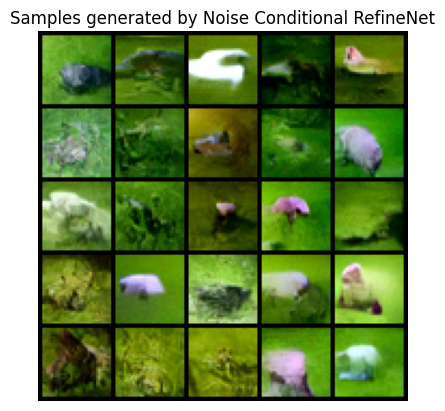

In [116]:
visualize_samples(samples, title='Samples generated by Noise Conditional RefineNet')

###UNet

In [55]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()
samples, history = Langevin(unet_mnist_1, n_samples=25, n_steps=100,
                            sigmas=sigmas, save_history=True, eps=5e-5)

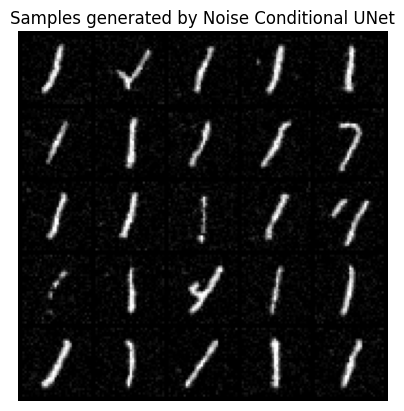

In [56]:
visualize_samples(samples, title='Samples generated by Noise Conditional UNet')

In [52]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(5), np.log(0.01), 10))).float()
samples, history = Langevin(unet_mnist_5, n_samples=25, n_steps=100,
                            sigmas=sigmas, save_history=True, eps=5e-5)

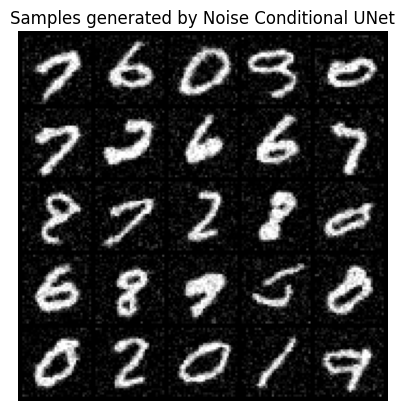

In [53]:
visualize_samples(samples, title='Samples generated by Noise Conditional UNet')

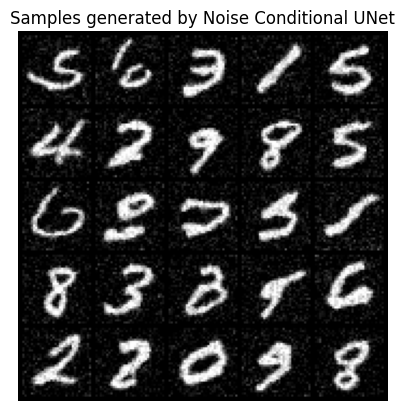

In [117]:
visualize_samples(samples, title='Samples generated by Noise Conditional UNet')

In [104]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(5), np.log(0.01), 10))).float()
samples, history = Langevin(unet_mnist_5, n_samples=5, n_steps=100,
                            sigmas=sigmas, save_history=True)

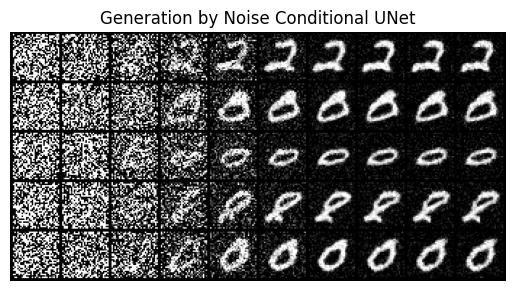

In [106]:
visualize_samples(samples, history, title='Generation by Noise Conditional UNet')

In [113]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(10), np.log(0.01), 10))).float()
samples, history = Langevin(unet_mnist_10, n_samples=25, n_steps=100,
                            sigmas=sigmas, save_history=True)

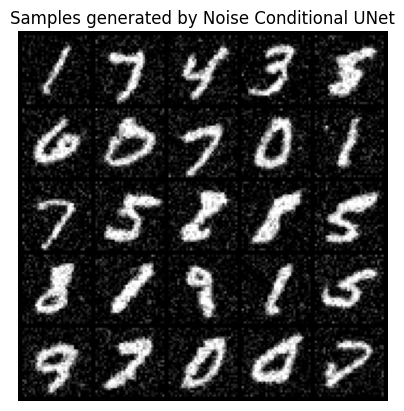

In [114]:
visualize_samples(samples, title='Samples generated by Noise Conditional UNet')

In [ ]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(10), np.log(0.01), 10))).float()
samples, history = Langevin(unet_mnist_10, n_samples=5, n_steps=100,
                            sigmas=sigmas, save_history=True)

In [ ]:
visualize_samples(samples, history, title='Generation by Noise Conditional UNet')

## Diffusion

In [33]:
ddpm.eval()
beta = torch.tensor(np.linspace(1e-4, 0.02, 1000)).float()
samples, history = reverse_diffusion(ddpm, n_samples=25, n_steps=1000, beta=beta, save_history=True)

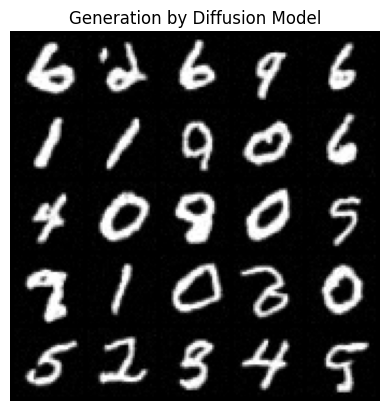

In [34]:
visualize_samples(samples, title='Generation by Diffusion Model')

In [39]:
beta = torch.tensor(np.linspace(1e-4, 0.02, 1000)).float()
samples, history = reverse_diffusion(ddpm, n_samples=5, n_steps=1000, beta=beta, save_history=True)

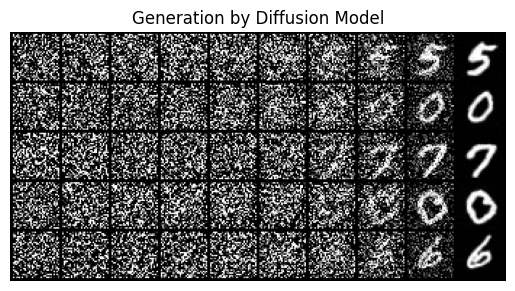

In [40]:
visualize_samples(samples, history, title='Generation by Diffusion Model')

# Denoising

In [ ]:
#batch_28 = next(iter(mnist_dataloader_28))
#batch_32 = next(iter(mnist_dataloader_32))

## Score-matching

In [58]:
def denoising(image, model, sigma_max=1., title=''):
  if USE_CUDA:
    image = image.to('cuda')

  sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_max), np.log(0.01), 10))).float()
  batch = image.repeat(10, 1, 1, 1)
  labels = torch.arange(len(sigmas)).to(batch.device)
  sigma_batch = sigmas.to(batch.device)
  sigma_batch = sigma_batch.reshape(-1, *([1]*(len(batch.shape) - 1)))

  standart_noise = torch.randn_like(batch)
  batch_noisy = batch + standart_noise * sigma_batch
  score = model(batch_noisy, labels)

  denoised = score * sigma_batch**2 + batch_noisy

  batch_noisy = batch_noisy.detach().cpu()
  denoised = denoised.detach().cpu()

  plt.figure(figsize=(15, 4))
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(batch_noisy[i].permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")
    plt.title(r'$\sigma$ = %.2f' % (sigmas[i]))
    plt.subplot(2, 10, i + 11)
    plt.imshow(denoised[i].permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")

   # sample = grad_desc(model, n_samples=1, sigmas=sigmas,
   #                   n_steps=100, x_0=batch_noisy[i:i+1], start_iter=i)
   # plt.subplot(3, 10, i + 21)
   # plt.imshow(sample[0].permute(1, 2, 0).clip(0, 1), cmap='Greys')
   # plt.axis("off")

  plt.suptitle(title)
  plt.show()

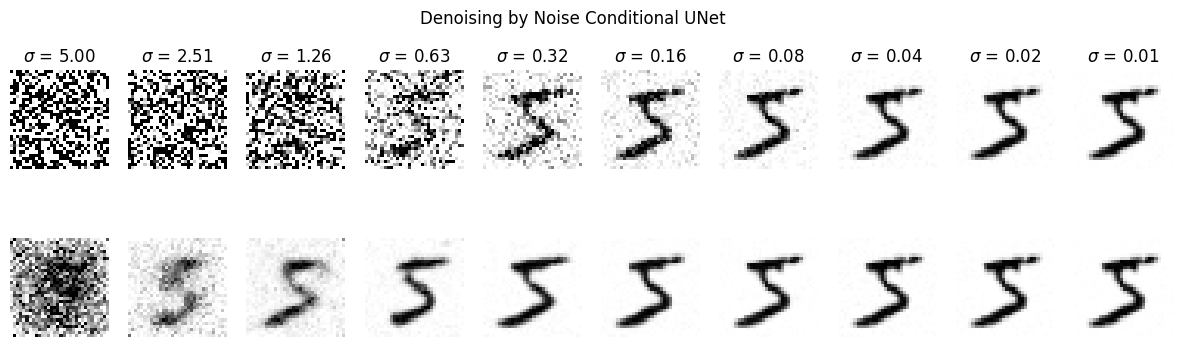

In [80]:
image = mnist_dataset_32[0][0].unsqueeze(0)
denoising(image, unet_mnist_5, sigma_max=5, title='Denoising by Noise Conditional UNet')

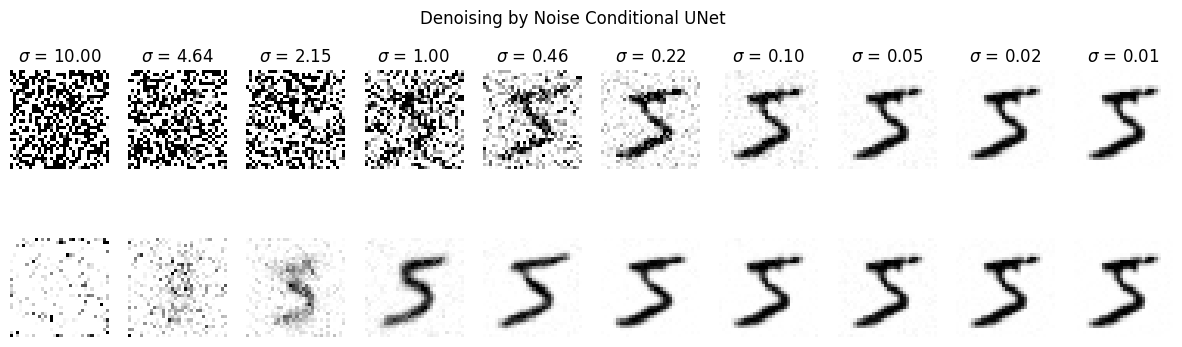

In [83]:
image = mnist_dataset_32[0][0].unsqueeze(0)
denoising(image, unet_mnist_10, sigma_max=10, title='Denoising by Noise Conditional UNet')

In [123]:
def denoising_2(image, model, sigma_max=1., title=''):
  if USE_CUDA:
    image = image.to('cuda')

  sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_max), np.log(0.01), 10))).float()
  batch = image.repeat(10, 1, 1, 1)
  labels = torch.arange(len(sigmas)).to(batch.device)
  sigma_batch = sigmas.to(batch.device)
  sigma_batch = sigma_batch.reshape(-1, *([1]*(len(batch.shape) - 1)))

  standart_noise = torch.randn_like(batch)
  batch_noisy = batch + standart_noise * sigma_batch
  score = model(batch_noisy, labels)

  denoised = score * sigma_batch**2 + batch_noisy

  batch_noisy = batch_noisy.detach().cpu()
  denoised = denoised.detach().cpu()

  plt.figure(figsize=(15, 4))
  for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(batch_noisy[i].permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")
    plt.title(r'$\sigma$ = %.2f' % (sigmas[i]))

    sample = Langevin(model, n_samples=1, sigmas=sigmas, eps=2e-5,
                      n_steps=100, x_0=batch_noisy[i:i+1], start_iter=i)

    plt.subplot(3, 10, i + 11)
    plt.imshow(sample[0].permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")

    sample = grad_desc(model, n_samples=1, sigmas=sigmas,
                      n_steps=100, x_0=batch_noisy[i:i+1], start_iter=i)
    plt.subplot(3, 10, i + 21)
    plt.imshow(sample[0].permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")

  plt.suptitle(title)
  plt.show()

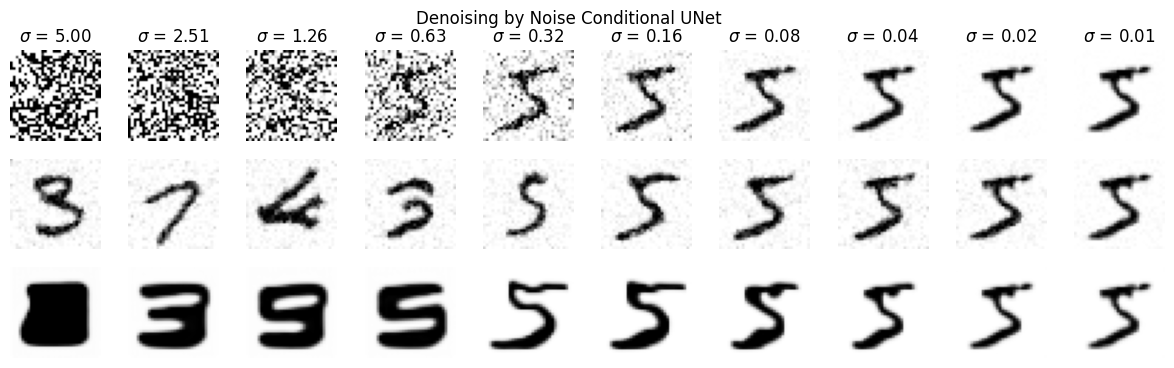

In [124]:
image = mnist_dataset_32[0][0].unsqueeze(0)
denoising_2(image, unet_mnist_5, sigma_max=5, title='Denoising by Noise Conditional UNet')

## Diffusion

In [102]:
def denoising_diffusion(image, model, title=''):
  if USE_CUDA:
    image = image.to('cuda')

  beta = torch.tensor(np.linspace(1e-4, 0.02, 1000)).float()
  image = image.repeat(10, 1, 1, 1)
  labels = torch.arange(len(beta) - 1, 0, -100)

  alpha_hat = torch.cumprod(1 - beta, 0)
  alpha_batch = alpha_hat[labels].to(image.device)
  alpha_batch = alpha_batch.reshape(-1, *([1]*(len(image.shape) - 1)))

  standart_noise = torch.randn_like(image)
  batch_noisy = torch.sqrt(alpha_batch) * image + standart_noise * torch.sqrt(1 - alpha_batch)


  plt.figure(figsize=(15, 4))
  for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(image[i].detach().cpu().permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.title(r'$t$ = %i' % (labels[i]))
    plt.axis("off")
    plt.subplot(3, 10, i + 11)
    plt.imshow(batch_noisy[i].detach().cpu().permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")
    plt.subplot(3, 10, i + 21)
    denoised = reverse_diffusion(model, n_samples=1, n_steps=1000, beta=beta, x_0=batch_noisy[i:i+1], start_iter=(1000 - labels[i]))
    plt.imshow(denoised[0].permute(1, 2, 0).clip(0, 1), cmap='Greys')
    plt.axis("off")

  plt.suptitle(title)
  plt.show()

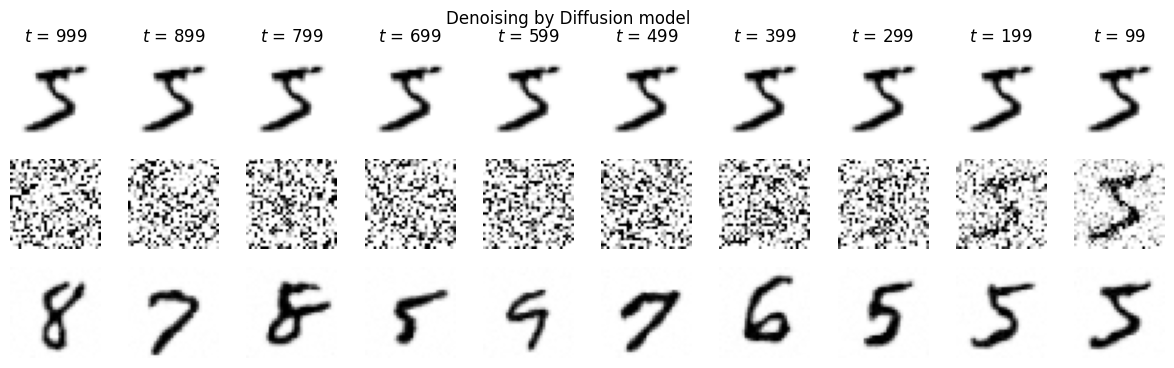

In [103]:
image = mnist_dataset_32[0][0].unsqueeze(0)
denoising_diffusion(image, ddpm, title='Denoising by Diffusion model')

# Interpolation

## Score-matching

In [59]:
def iterpolation(model, sigmas, int_steps=10, mix_step=0):
  noise = model.prior(2)

  if mix_step != 0:
    sample, history = Langevin(model, n_samples=2, sigmas=sigmas,
                               n_steps=100, x_0=noise, start_iter=0,
                               save_history=True)
    noise = history[mix_step - 1]

  x_0 = torch.stack([noise[0] * a + noise[1] * (1 - a) for a in np.linspace(0, 1, int_steps)])
  sample = Langevin(model, n_samples=int_steps, sigmas=sigmas,
                    n_steps=100, x_0=x_0, start_iter=mix_step)
  return sample

In [60]:
def Langevin_interpolation(model,
                           x_0: torch.Tensor,
                           sigma_max: int=1,
                           n_steps=100,
                           int_steps=10,
                           eps: float = 0.00005,
                           mix_step: int = 0) -> torch.Tensor:

    x_k = x_0
    if USE_CUDA:
      x_k = x_k.cuda()

    n_samples = 2
    sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_max), np.log(0.01), 10))).float()

    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        if i == mix_step:
          x_k = torch.stack([x_k[0] * a + x_k[1] * (1 - a) for a in np.linspace(0, 1, int_steps)])
          n_samples = int_steps

        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * i
          score = model(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)


    return x_k.cpu()

In [136]:
noise = unet_mnist_5.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
samples_4 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=4)
samples_8 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)

In [137]:
samples = torch.stack([samples_0, samples_4, samples_8]).reshape(-1, *samples_0.shape[1:])

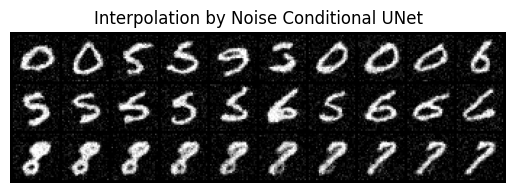

In [138]:
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

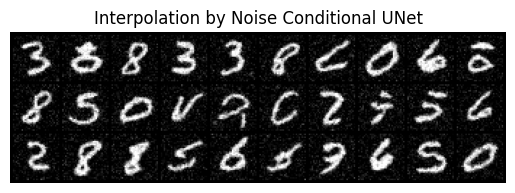

In [140]:
noise = unet_mnist_5.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
noise = unet_mnist_5.prior(2)
samples_1 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
noise = unet_mnist_5.prior(2)
samples_2 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

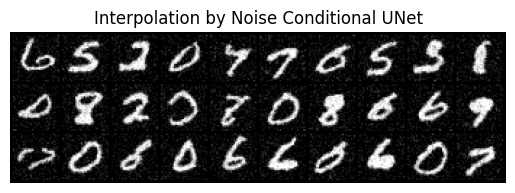

In [143]:
noise = unet_mnist_5.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
noise = unet_mnist_5.prior(2)
samples_1 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
noise = unet_mnist_5.prior(2)
samples_2 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=0)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

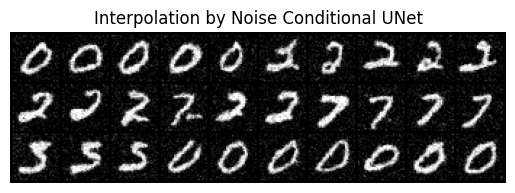

In [141]:
noise = unet_mnist_5.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=4)
noise = unet_mnist_5.prior(2)
samples_1 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=4)
noise = unet_mnist_5.prior(2)
samples_2 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=4)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

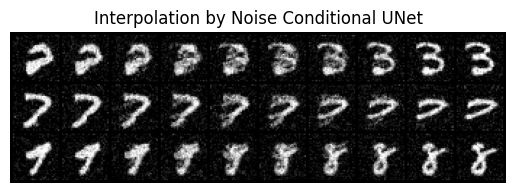

In [142]:
noise = unet_mnist_5.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)
noise = unet_mnist_5.prior(2)
samples_1 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)
noise = unet_mnist_5.prior(2)
samples_2 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

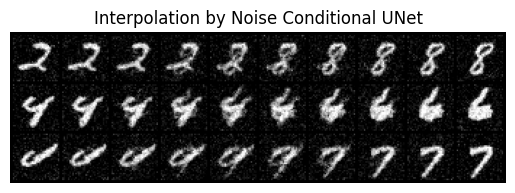

In [144]:
noise = unet_mnist_5.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)
noise = unet_mnist_5.prior(2)
samples_1 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)
noise = unet_mnist_5.prior(2)
samples_2 = Langevin_interpolation(unet_mnist_5, sigma_max=5, x_0=noise, mix_step=8)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

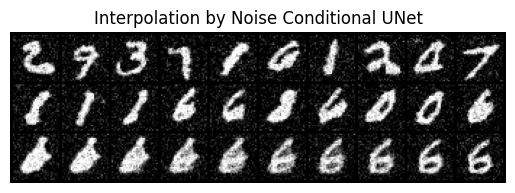

In [139]:
noise = unet_mnist_10.prior(2)
samples_0 = Langevin_interpolation(unet_mnist_10, sigma_max=10, x_0=noise, mix_step=0)
samples_4 = Langevin_interpolation(unet_mnist_10, sigma_max=10, x_0=noise, mix_step=4)
samples_8 = Langevin_interpolation(unet_mnist_10, sigma_max=10, x_0=noise, mix_step=8)
samples = torch.stack([samples_0, samples_4, samples_8]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Noise Conditional UNet')

## Diffusion

In [104]:
def diffusion_interpolation(model,
                            n_steps: int = 1000,
                            x_0: torch.Tensor = None,
                            mix_step: int = 0,
                            int_steps: int = 10) -> torch.Tensor:

  x_k = x_0
  if USE_CUDA:
    x_k = x_k.cuda()

  n_samples = 2

  history = []

  beta = torch.tensor(np.linspace(1e-4, 0.02, 1000)).float()
  alpha_hat = torch.cumprod(1 - beta, 0)
  with torch.no_grad():
    for t in range(n_steps - 1, -1, -1):
      if t == mix_step:
          x_k = torch.stack([x_k[0] * a + x_k[1] * (1 - a) for a in np.linspace(0, 1, int_steps)])
          n_samples = int_steps

      t_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * t
      noise = model(x_k, t_batch)
      sigma_t = np.sqrt(beta[t])
      noise_coef = beta[t] / np.sqrt(1 - alpha_hat[t])
      x_k = (x_k - noise_coef * noise.detach()) / np.sqrt(1 - beta[t]) + sigma_t * torch.randn_like(x_k)


  return x_k.cpu()

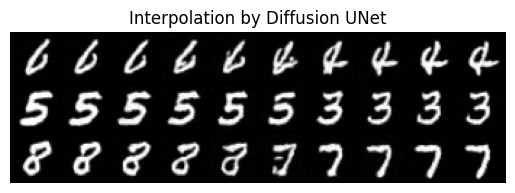

In [110]:
noise = ddpm.prior(2)
samples_0 = diffusion_interpolation(ddpm, x_0=noise, mix_step=100)
noise = ddpm.prior(2)
samples_1 = diffusion_interpolation(ddpm, x_0=noise, mix_step=100)
noise = ddpm.prior(2)
samples_2 = diffusion_interpolation(ddpm, x_0=noise, mix_step=100)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Diffusion UNet')

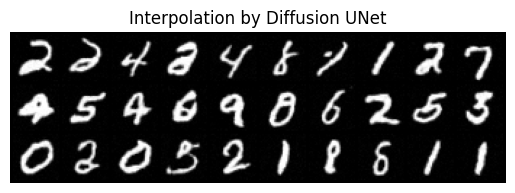

In [108]:
noise = ddpm.prior(2)
samples_0 = diffusion_interpolation(ddpm, x_0=noise, mix_step=500)
noise = ddpm.prior(2)
samples_1 = diffusion_interpolation(ddpm, x_0=noise, mix_step=500)
noise = ddpm.prior(2)
samples_2 = diffusion_interpolation(ddpm, x_0=noise, mix_step=500)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Diffusion UNet')

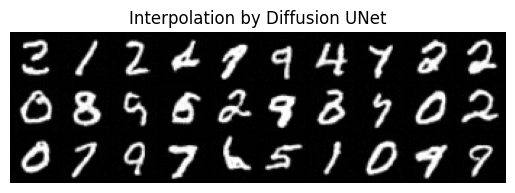

In [109]:
noise = ddpm.prior(2)
samples_0 = diffusion_interpolation(ddpm, x_0=noise, mix_step=800)
noise = ddpm.prior(2)
samples_1 = diffusion_interpolation(ddpm, x_0=noise, mix_step=800)
noise = ddpm.prior(2)
samples_2 = diffusion_interpolation(ddpm, x_0=noise, mix_step=800)
samples = torch.stack([samples_0, samples_1, samples_2]).reshape(-1, *samples_0.shape[1:])
visualize_samples(samples, nrow=10,
                  title='Interpolation by Diffusion UNet')